# TP Integrador Aprendizaje Automático I

### Librerías

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

### Carga de datos y exploración

In [170]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

In [171]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [172]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [173]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object


In [174]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [175]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

In [176]:
df[df['RainToday']]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
9,405,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,True,False,0.0
11,407,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,...,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,True,True,15.6
12,408,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,...,93.0,994.3,993.0,8.0,8.0,17.4,15.8,True,True,3.6
13,409,Albury,12.6,21.0,3.6,NaN,NaN,SW,44.0,W,...,43.0,1001.2,1001.8,NaN,7.0,15.8,19.8,True,False,0.0
17,413,Albury,13.5,22.9,16.8,NaN,NaN,W,63.0,N,...,65.0,1005.8,1002.2,8.0,1.0,18.0,21.5,True,True,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145278,3390,Uluru,22.2,39.4,6.2,NaN,NaN,S,30.0,S,...,25.0,1008.4,1004.9,NaN,4.0,28.6,38.7,True,False,0.2
145344,3456,Uluru,15.2,21.5,6.8,NaN,NaN,ENE,30.0,NE,...,65.0,1016.9,1015.3,3.0,8.0,19.0,21.2,True,True,12.6
145345,3457,Uluru,17.7,26.9,12.6,NaN,NaN,S,35.0,E,...,59.0,1018.1,1014.7,7.0,8.0,19.0,26.0,True,True,34.6
145346,3458,Uluru,18.6,28.6,34.6,NaN,NaN,E,46.0,E,...,56.0,1020.0,1015.8,8.0,5.0,19.8,26.9,True,True,3.8


In [177]:
#Se mapean las direcciones dadas ('SSW', 'S', 'SE', etc.) a números del 0 al 15 según las agujas del reloj
directions_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

In [178]:
# Se reemplaza en df los nuevos valores
df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
df['WindDir3pm'] = df['WindDir3pm'].replace(directions_mapping)

In [179]:
#Se conserva el df original para las 49 ciudades
df_49=df

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]

In [180]:
df.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,28233.000000,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26588.000000,26591.000000,26585.000000,27796.000000,...,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,1913.110367,11.263319,21.902078,2.050369,4.826499,6.891129,7.711110,41.835471,7.376378,8.048928,...,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,948.862211,5.709936,6.693168,6.384560,3.707995,3.867622,4.694183,14.186300,5.054644,4.503144,...,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,1082.000000,7.400000,16.600000,0.000000,2.200000,3.800000,4.000000,31.000000,2.000000,4.000000,...,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,1955.000000,10.900000,21.000000,0.000000,4.000000,7.400000,8.000000,39.000000,8.000000,8.000000,...,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,2739.000000,15.200000,26.200000,1.000000,6.600000,10.000000,12.000000,50.000000,12.000000,12.000000,...,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,3523.000000,33.900000,46.800000,119.400000,86.200000,14.300000,15.000000,122.000000,15.000000,15.000000,...,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


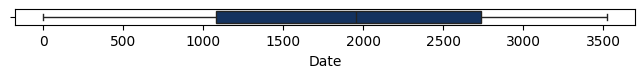

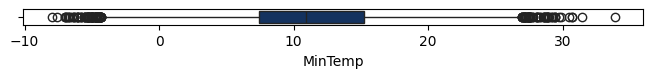

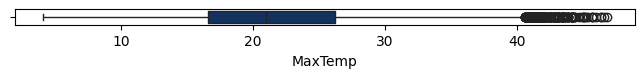

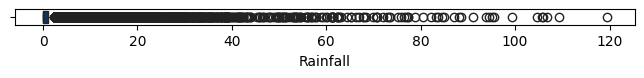

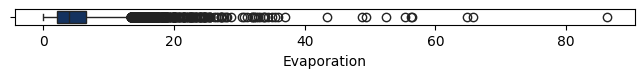

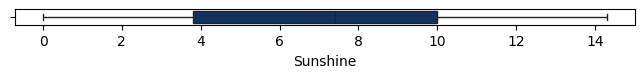

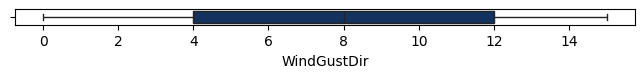

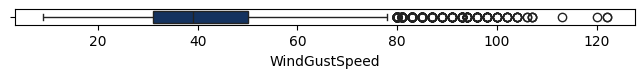

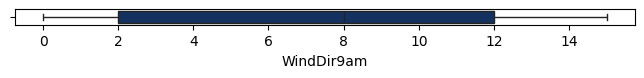

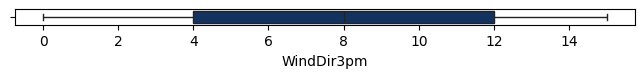

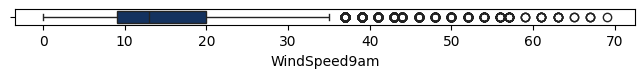

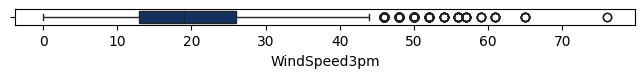

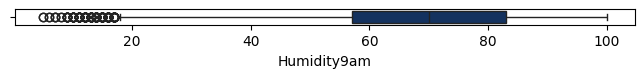

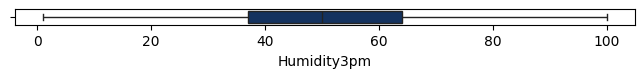

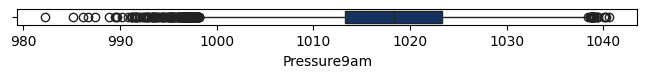

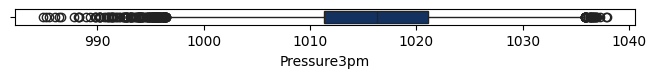

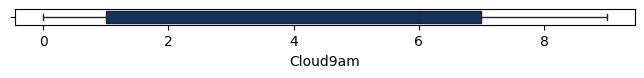

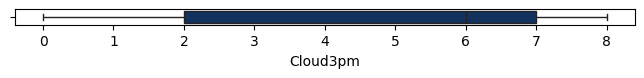

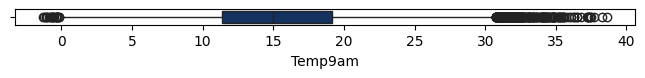

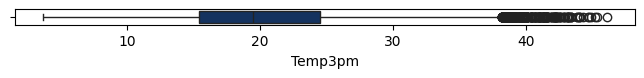

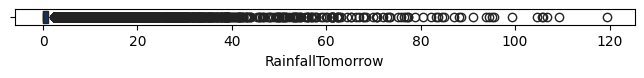

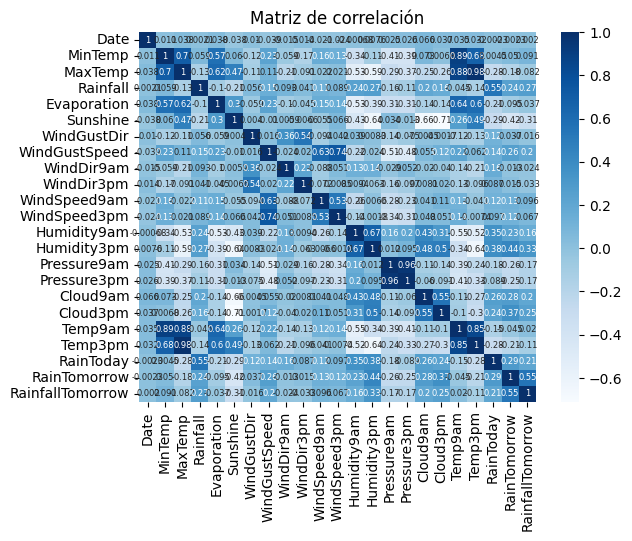

In [181]:
explorar(df)

### Imputación de nulos

#### Primeros análisis

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 5% del total de registros. Se observa que el segundo valor supera al primero, por lo que deberá analizarse el tratamiento a dar a los valores nan para su reemplazo.

Observación: todo el análisis se hará sobre el df antes de dividirlo, ya que como se separará de manera cronológica no se generarán contaminación de datos entre ambos conjuntos.

In [182]:
print(f'Número máximo de filas para eliminar: {int(0.05 * df.shape[0])}')

Número máximo de filas para eliminar: 1411


In [183]:
# Contar filas que contienen al menos un valor NaN
nan_rows_count = df.isna().any(axis=1).sum()

# Imprimir el resultado
print(f'Número de filas con al menos un valor NaN: {nan_rows_count}')


Número de filas con al menos un valor NaN: 14773


In [184]:
### Cantidad de valores faltantes.
df.isna().sum().sort_values(ascending=False)

Cloud3pm            9550
Cloud9am            9367
Sunshine            6713
Evaporation         4353
WindDir9am          1648
WindGustDir         1645
WindGustSpeed       1642
Rainfall             986
RainToday            986
RainfallTomorrow     985
RainTomorrow         985
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Temp9am              585
Temp3pm              576
MinTemp              570
MaxTemp              558
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Location               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

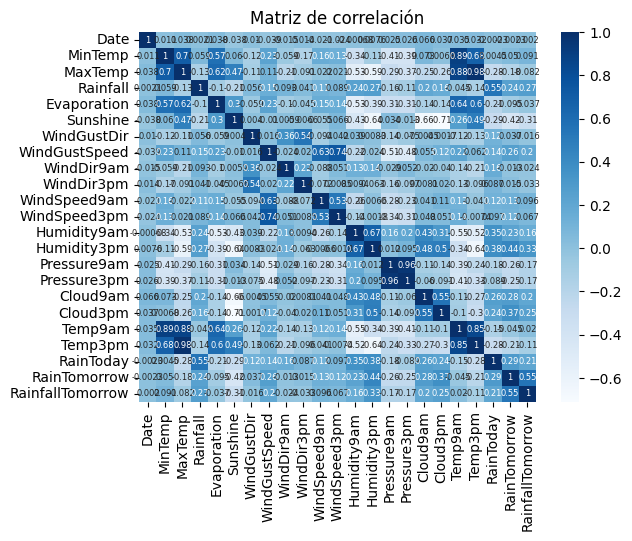

In [185]:
matriz_corr(df)

Se observa que la mayoría de las variables no presenta una fuerte correlación con las demás, por lo que no resulta válido reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre todas las ciudades del df original, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [188]:
# Coordenadas de las ciudades
cities_coords_9 = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Albany': (-35.0228, 117.8814),
    'AliceSprings': (-23.6980, 133.8807),
    'Albury': (-36.0737, 146.9135),
    'BadgerysCreek': (-33.8817, 150.7440),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7570, 144.2784),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9186, 145.7781),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'CoffsHarbour': (-30.2963, 153.1157),
    'Darwin': (-12.4634, 130.8456),
    'Dartmoor': (-37.9225, 141.2760),
    'GoldCoast': (-28.0167, 153.4000),
    'Hobart': (-42.8821, 147.3272),
    'Katherine': (-14.4646, 132.2635),
    'Launceston': (-41.4341, 147.1374),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Mildura': (-34.1847, 142.1625),
    'Moree': (-29.4658, 149.8407),
    'MountGambier': (-37.8284, 140.7804),
    'MountGinini': (-35.5294, 148.7744),
    'Newcastle': (-32.9272, 151.7765),
    'Nhil': (-36.3348, 141.6503),
    'NorahHead': (-33.2821, 151.5671),
    'NorfolkIsland': (-29.0408, 167.9547),
    'Nuriootpa': (-34.4694, 138.9939),
    'Penrith': (-33.7511, 150.6942),
    'Perth': (-31.9505, 115.8605),
    'PerthAirport': (-31.9403, 115.9672),
    'PearceRAAF': (-31.6736, 116.0174),
    'Portland': (-38.3463, 141.6042),
    'Richmond': (-33.5995, 150.7391),
    'Sale': (-38.1118, 147.0680),
    'SalmonGums': (-32.9815, 121.6438),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'Townsville': (-19.2580, 146.8169),
    'Tuggeranong': (-35.4244, 149.0888),
    'Uluru': (-25.3455, 131.0369),
    'WaggaWagga': (-35.1082, 147.3598),
    'Walpole': (-34.9777, 116.7338),
    'Watsonia': (-37.7110, 145.0830),
    'Williamtown': (-32.8150, 151.8428),
    'Witchcliffe': (-34.0261, 115.1003),
    'Wollongong': (-34.4278, 150.8931),
    'Woomera': (-31.1994, 136.8253)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide   Albany AliceSprings   Albury BadgerysCreek  \
Adelaide              0.0   1888.6      1326.08   764.58       1121.82   
Albany             1888.6      0.0      1992.48  2625.31       3008.83   
AliceSprings      1326.08  1992.48          0.0  1858.21       1991.62   
Albury             764.58  2625.31      1858.21      0.0        425.94   
BadgerysCreek     1121.82  3008.83      1991.62   425.94           0.0   
Ballarat           554.88   2342.2       1807.3   319.32        745.19   
Bendigo            551.48  2383.56      1757.34   248.19        668.67   
Brisbane           1601.7   3431.8      1966.04   1115.3        743.63   
Cairns            2119.21  3418.42      1450.56  2125.39       1943.74   
Canberra           960.32  2835.57      1953.86   219.08        214.52   
Cobar              773.97  2625.02      1461.11   517.23        530.79   
CoffsHarbour      1454.23  3329.19      2040.92   862.77        456.25   
Darwin            2608.53  2820.24    

In [194]:
# Crear un mapa centrado en Australia
mapa = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)  # zoom_start ajustable según la necesidad

# Añadir marcadores naranjas para las ciudades en cities_coords_9
for city, coords in cities_coords_9.items():
    folium.Marker(
        location=coords,
        popup=city,
        icon=folium.Icon(color='orange')
    ).add_to(mapa)

# Añadir marcadores azules para las ciudades que están en cities_coords pero no en cities_coords_9
for city, coords in cities_coords.items():
    if city not in cities_coords_9:
        folium.Marker(
            location=coords,
            popup=city,
            icon=folium.Icon(color='blue')
        ).add_to(mapa)

In [195]:
# Mostrar el mapa
mapa

#### Análisis nan por distancias

Se crea la función general procesar_geo_nan, que permite analizar y reemplazar los datos nulos por aquellos del mismo día para ciudades vecinas, con un radio de km a definir.

Luego, se hace un análisis pormenorizado de los demás valores nulos, reemplazando con datos de ciudades más lejanas pero en donde se observa una buena correlación de los datos, utilizando gráficos de dispersión para comparar entre ciudades.

In [196]:
df = procesar_geo_nan(df, df_49, dist_matrix, cities_coords, 350)

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 350
Analizando la variable: MinTemp
Resultado del análisis geográfico:
         Location  MinTemp NaN Count   Nearest City Distance (km)
0      Melbourne                480       Watsonia         15.53
1       Dartmoor                 69   MountGambier         44.84
2          Cobar                  6     WaggaWagga        424.81
3       Canberra                  6    Tuggeranong         16.36
4         Sydney                  4  SydneyAirport          8.49
5       Adelaide                  2      Nuriootpa         62.38
6   MountGambier                  2       Dartmoor         44.84
7  SydneyAirport                  1         Sydney 

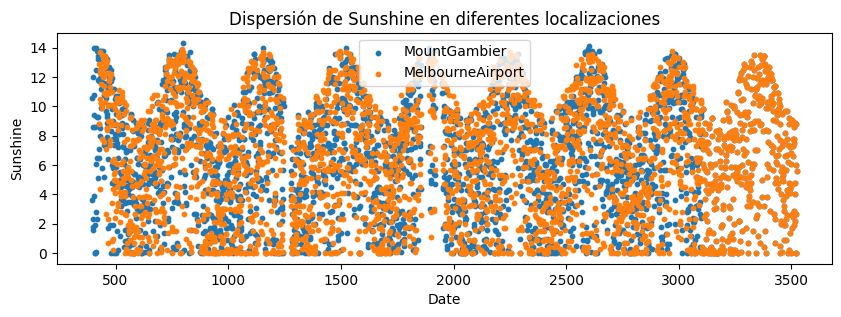

,Location,Sunshine NaN Count,Nearest City,Distance (km)
0,Cobar,12,WaggaWagga,424.81
1,Adelaide,12,Nuriootpa,62.38
2,Sydney,8,SydneyAirport,8.49
3,SydneyAirport,8,Sydney,8.49
4,Canberra,3,Tuggeranong,16.36


In [200]:
variable='Sunshine'
location='MountGambier'
location_near='MelbourneAirport'
graf_dispersion_comparativa(df, [location, location_near], 'Date',variable)
analisis_geo_nan(df, variable, dist_matrix, cities_coords)

In [199]:
df = recrear_geo_nan(df,df_49,'Cobar','Sydney','Sunshine')
df = recrear_geo_nan(df,df_49,'MountGambier','MelbourneAirport','Sunshine')

La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0


In [201]:
nan_rows_count_filtered = df.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN dentro de las variables predictivas: 1368


Se eliminan los registros con al menos un nan, ya que la suma total representa menos del 5% del total de datos.

In [202]:
df=df.dropna()
nan_rows_count_filtered = df.drop(columns=['RainTomorrow', 'RainfallTomorrow']).isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN dentro de las variables predictivas: {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN dentro de las variables predictivas: 0


### Partición del Dataframe

In [203]:
# Se chequea que todas las fechas tengan un valor
df['Date'].isna().sum()

0

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [204]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df[df['Date'] <= date_at_80_percent]
df_test = df[df['Date'] > date_at_80_percent]

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {len(df_train)} registros")
print(f"Prueba: {len(df_test)} registros")
print(f"Suma de registro Entrenamiento y Prueba: {len(df_test)+len(df_train)} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")


Entrenamiento: 20743 registros
Prueba: 5184 registros
Suma de registro Entrenamiento y Prueba: 25927 registros
Cantidad total de registros en df original: 25927 registros


### Modelos

#### Regresión lineal

In [205]:
df_train.dtypes

Date                  int64
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir         float64
WindGustSpeed       float64
WindDir9am          float64
WindDir3pm          float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday           boolean
RainTomorrow        boolean
RainfallTomorrow    float64
dtype: object

In [226]:
X_train = df_train.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1)
y_train = df_train[['RainfallTomorrow']]

In [227]:
X_test = df_test.drop(['Date', 'Location', 'RainTomorrow', 'RainfallTomorrow'], axis=1) 
y_test = df_test[['RainfallTomorrow']]

In [228]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20743, 20), (5184, 20), (20743, 1), (5184, 1))

In [229]:
model = make_pipeline(StandardScaler(), LinearRegression())

In [230]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

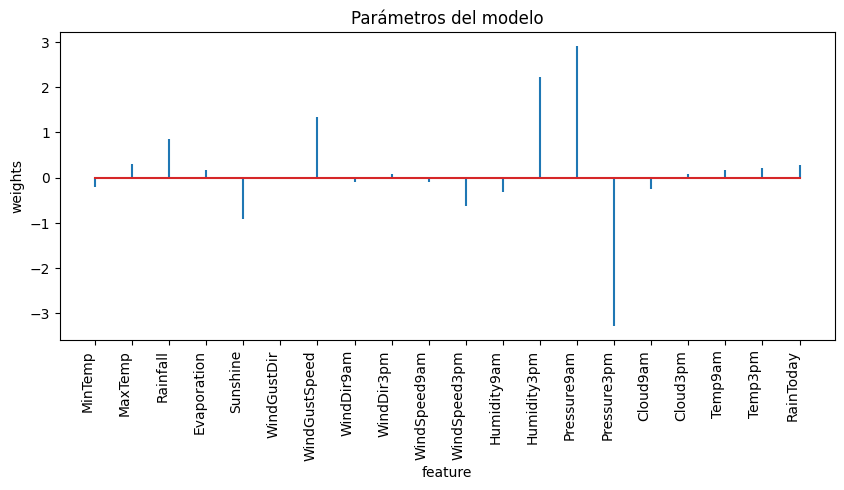

In [231]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': model.steps[1][1].coef_.flatten()})

fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

In [232]:
# Predicciones
y_pred = model.predict(X_test)
#predicciones = predicciones.flatten()
#predicciones[:10]
y_pred.shape, y_test.shape

((5184, 1), (5184, 1))

In [233]:
# Error de test del modelo. Uso rmse para mantener la misma escala que la variable a predecir
rmse_ols = mean_squared_error(y_test, y_pred, squared = False)
print(f"El error (rmse) de test es: {rmse_ols}")

El error (rmse) de test es: 5.54003415705252


In [235]:
R2 = metrics.r2_score(y_test, y_pred)
R2

0.23286474533494406

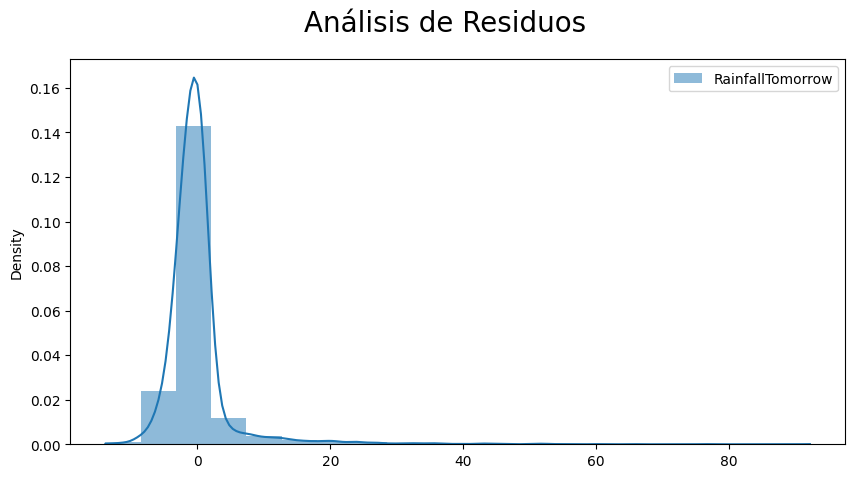

In [236]:
fig = plt.figure(figsize=(10,5))
  
sns.histplot((y_test - y_pred), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)    
plt.show()

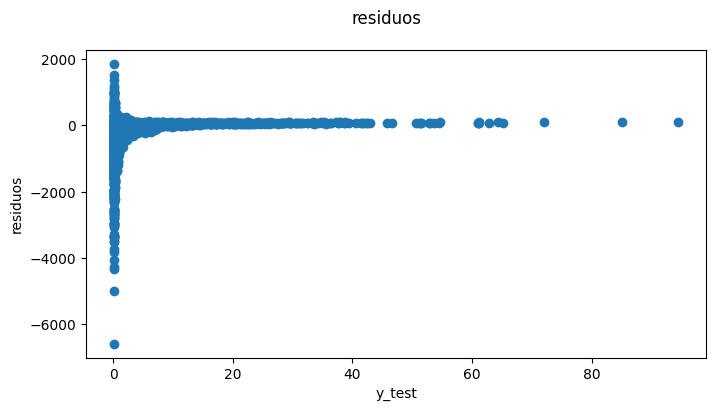

In [237]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test,100*(y_test-y_pred)/y_test)
plt.show()

#### Gradiente descendente

In [238]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20743, 20), (5184, 20), (20743, 1), (5184, 1))

In [239]:
gradient_descent(X_train, y_train, X_test, y_test, epochs=200, lr=0.00001)

ValueError: Unable to coerce to DataFrame, shape must be (20743, 1): given (20743, 21)

In [240]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [241]:
gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)

ValueError: Unable to coerce to DataFrame, shape must be (20743, 1): given (20743, 21)

In [242]:
stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)

KeyError: "None of [Index([ 6706, 15044,  2255, 17452, 20197,  7950, 10593, 19715, 15774, 16162,\n       ...\n       17238, 14570, 14507, 20374, 19397, 17822, 16951, 20731, 13860, 12706],\n      dtype='int32', length=20743)] are in the [columns]"

In [243]:
mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)

KeyError: "None of [Index([ 2115,  8393, 20591,  6463, 14961,  5386, 14178,  6709, 19677,  2476,\n       ...\n        6254,  2838,  6102, 15432, 19985, 19592,  3210, 16307, 19836,  8321],\n      dtype='int32', length=20743)] are in the [columns]"

#### Ridge Regression

In [ ]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

modelo = make_pipeline(StandardScaler(), 
                        RidgeCV(
                           alphas          = np.logspace(-10, 10, 200),
                           fit_intercept   = True,
                           store_cv_values = True
                        )
         )

_ = modelo.fit(X_train, y_train)

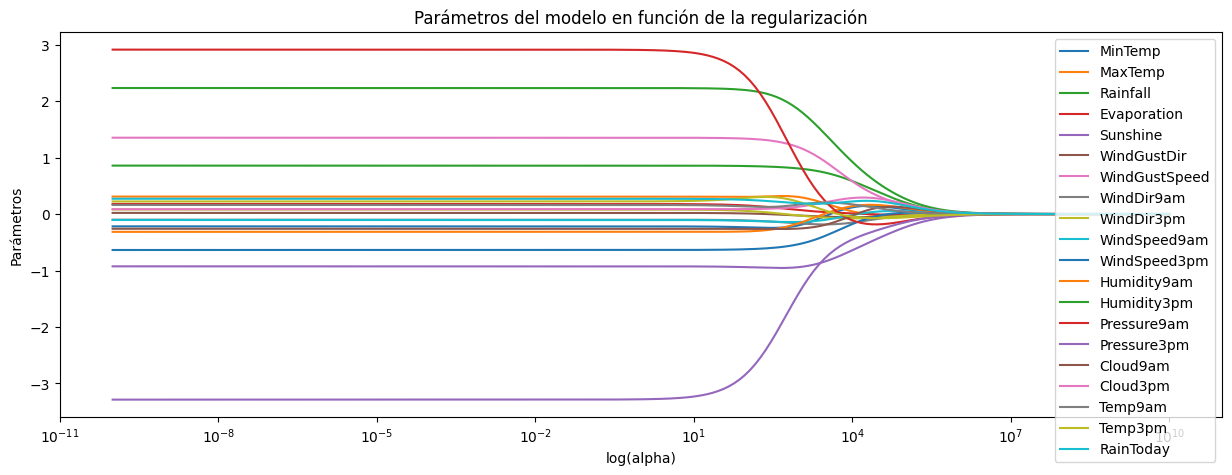

In [ ]:
# Evolución de los parámetros en función de alpha

alphas = modelo.steps[1][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

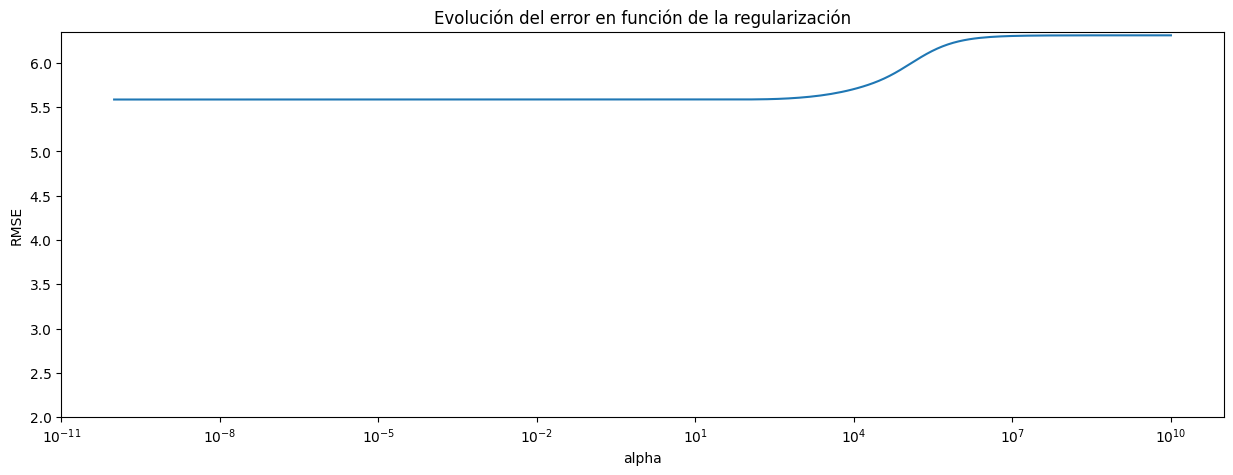

In [ ]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mod = modelo.steps[1][1]

mse_cv = mod.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 11.357333583431075


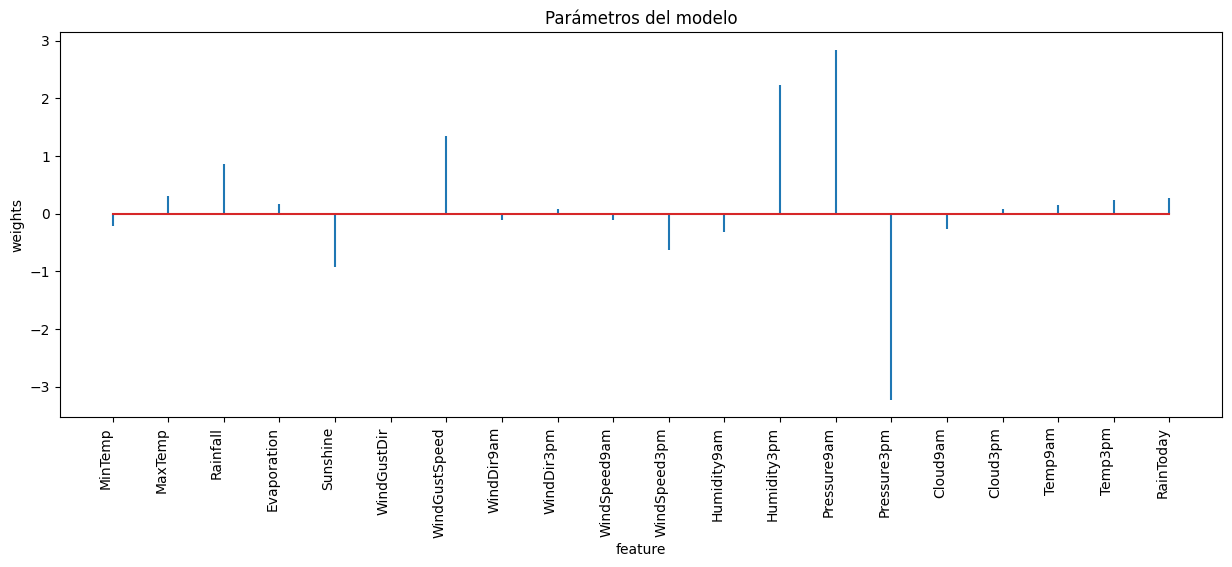

In [ ]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

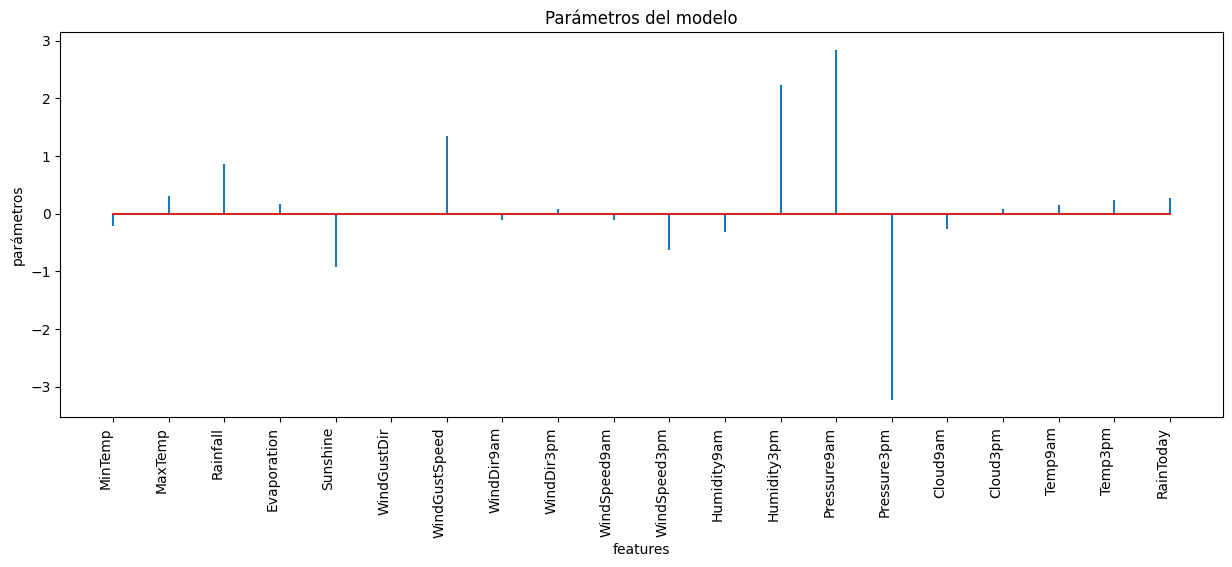

In [ ]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo 

rmse_ridge = mean_squared_error(y_test,
                y_pred,
                squared = False
             )

print(f"El error (rmse) de test es: {rmse_ridge}")

El error (rmse) de test es: 5.540386803079097


In [ ]:
R2 = metrics.r2_score(y_test, y_pred)
R2

0.2327670795798883

#### Lasso Regression

In [ ]:
modelo = make_pipeline(StandardScaler(), 
                        LassoCV(
                           alphas=np.logspace(-10, 10, 200),
                           cv=10
                        )
         )

_ = modelo.fit(X_train, y_train)

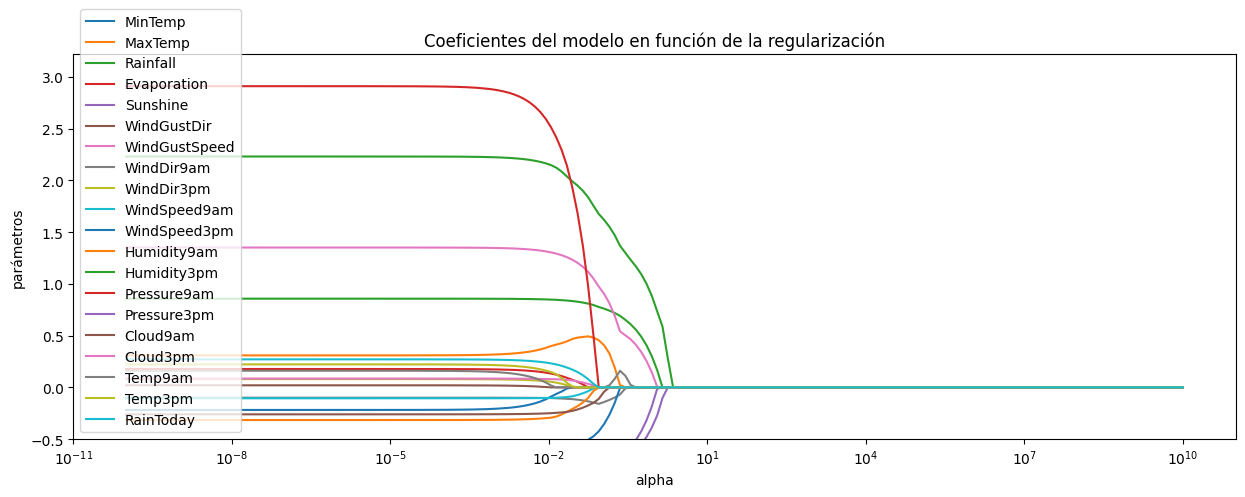

In [ ]:
# Evolución de los parámetros en función de alpha

mod = modelo.steps[1][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

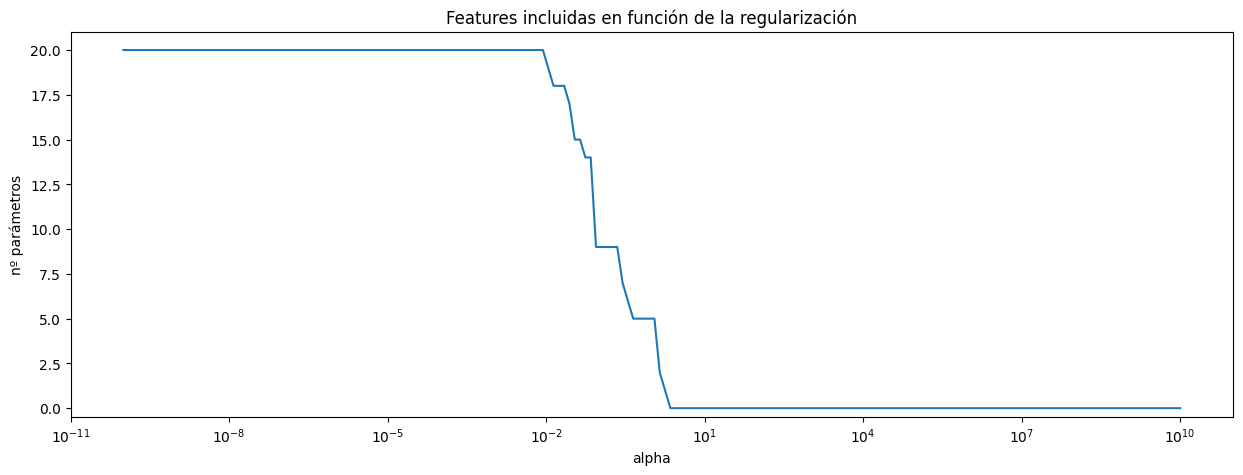

In [ ]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = mod.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.steps[1][1].coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

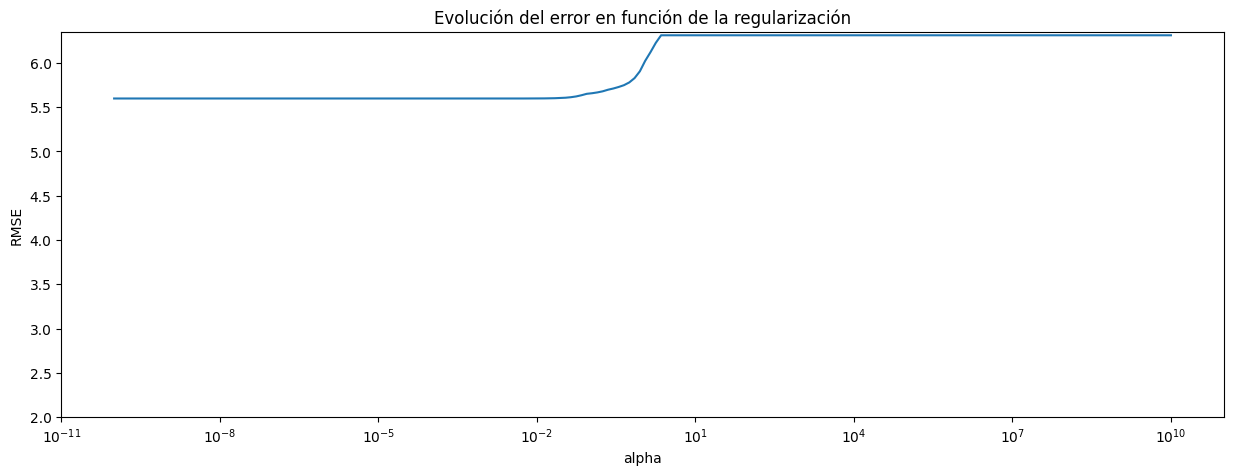

In [ ]:
# Evolución del error de validación cruzada en función de alpha

# modelo.mse_path almacena el MSE de CV para cada valor de alpha.

mse_cv = mod.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 0.0027364399970746718


In [ ]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,MinTemp,-0.185797
1,MaxTemp,0.332467
2,Rainfall,0.855104
3,Evaporation,0.166560
4,Sunshine,-0.922736
5,WindGustDir,0.014839
6,WindGustSpeed,1.339910
7,WindDir9am,-0.100433
8,WindDir3pm,0.073726
9,WindSpeed9am,-0.104679


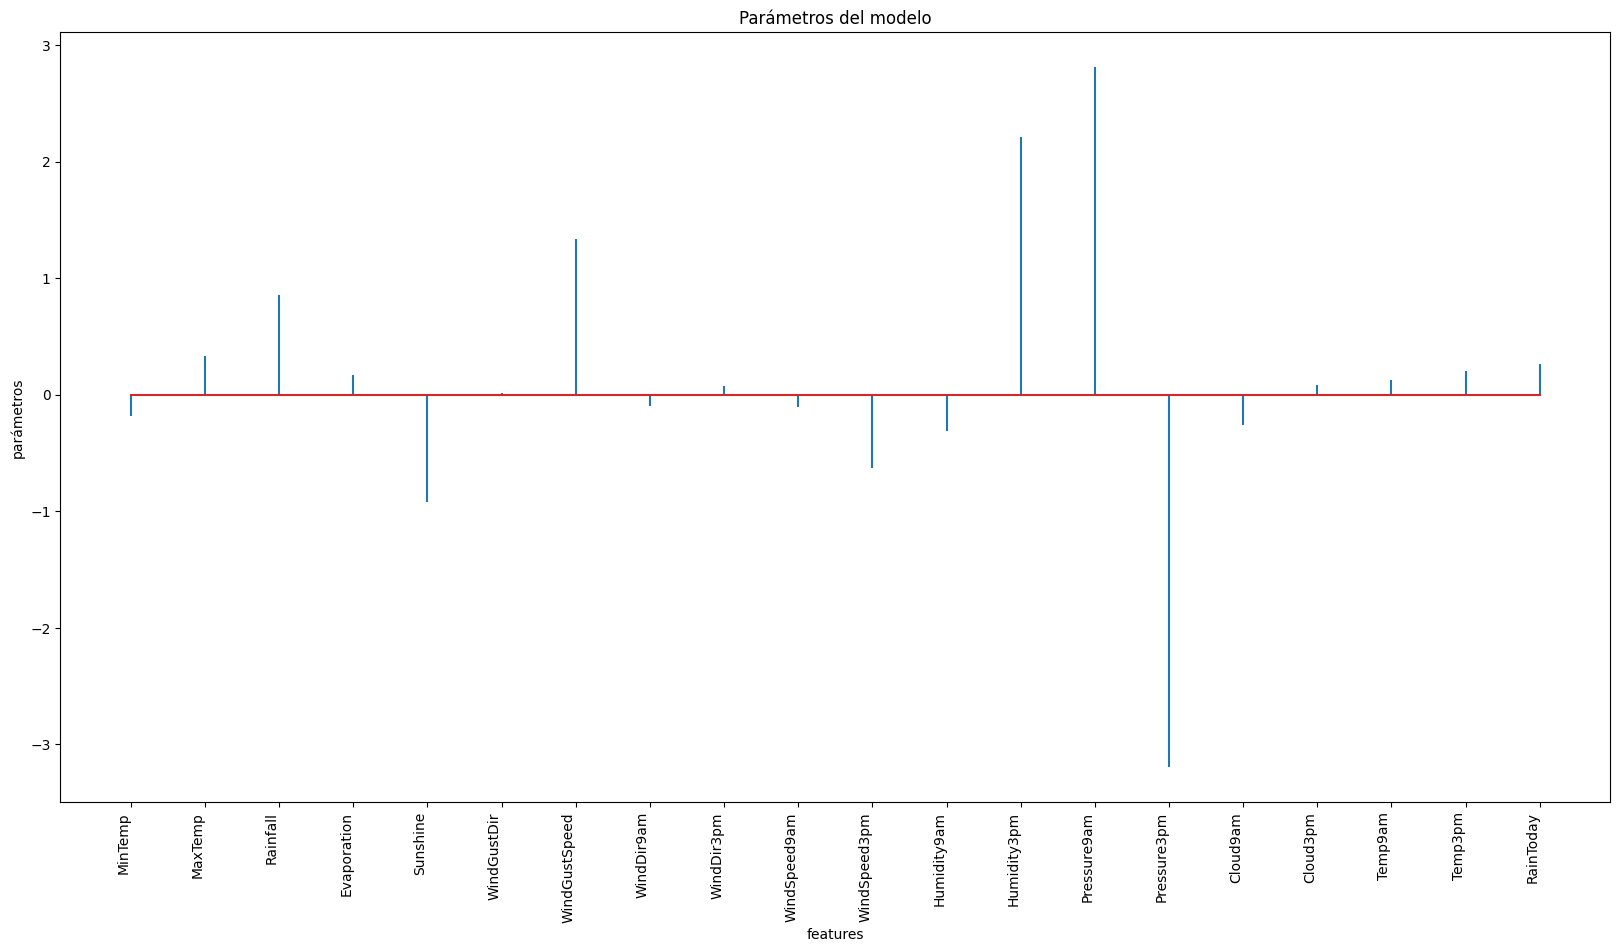

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo 

rmse_lasso = mean_squared_error(y_test,y_pred,squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 5.5408142302144965


In [ ]:
R2 = metrics.r2_score(y_test, y_pred)
R2

0.23264869477003758

#### ElasticNet

In [ ]:
modelo = make_pipeline(StandardScaler(), 
                        ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-10, 10, 200),
                              cv              = 10
                           )
         )

_ = modelo.fit(X_train, y_train)

mod = modelo.steps[1][1]

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,mod.alphas_,mse_cv,rmse_cv
327,0.10,1.722586e-03,31.319236,5.596359
127,0.00,1.722586e-03,31.319302,5.596365
326,0.10,2.171118e-03,31.319315,5.596366
328,0.10,1.366716e-03,31.319320,5.596367
128,0.00,1.366716e-03,31.319333,5.596368
...,...,...,...,...
1023,0.95,4.880252e+07,39.815908,6.309985
1024,0.95,3.872039e+07,39.815908,6.309985
1025,0.95,3.072113e+07,39.815908,6.309985
1019,0.95,1.231551e+08,39.815908,6.309985


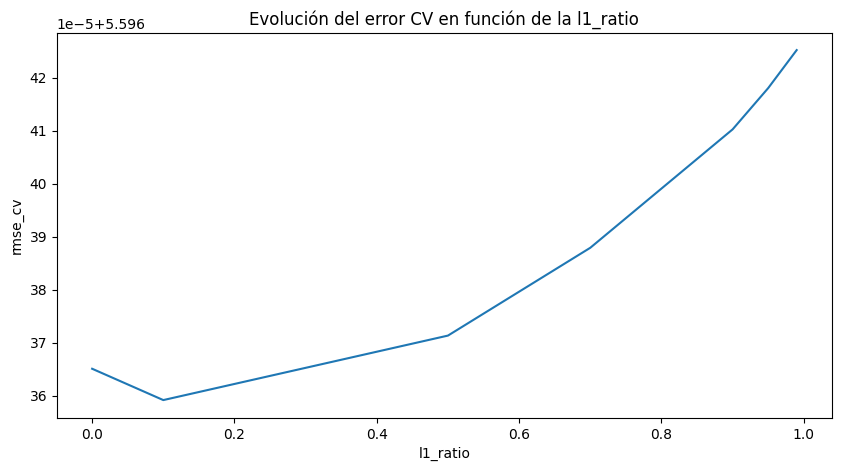

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.0017225859653987874
Mejor valor de l1_ratio encontrado: 0.1


In [ ]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

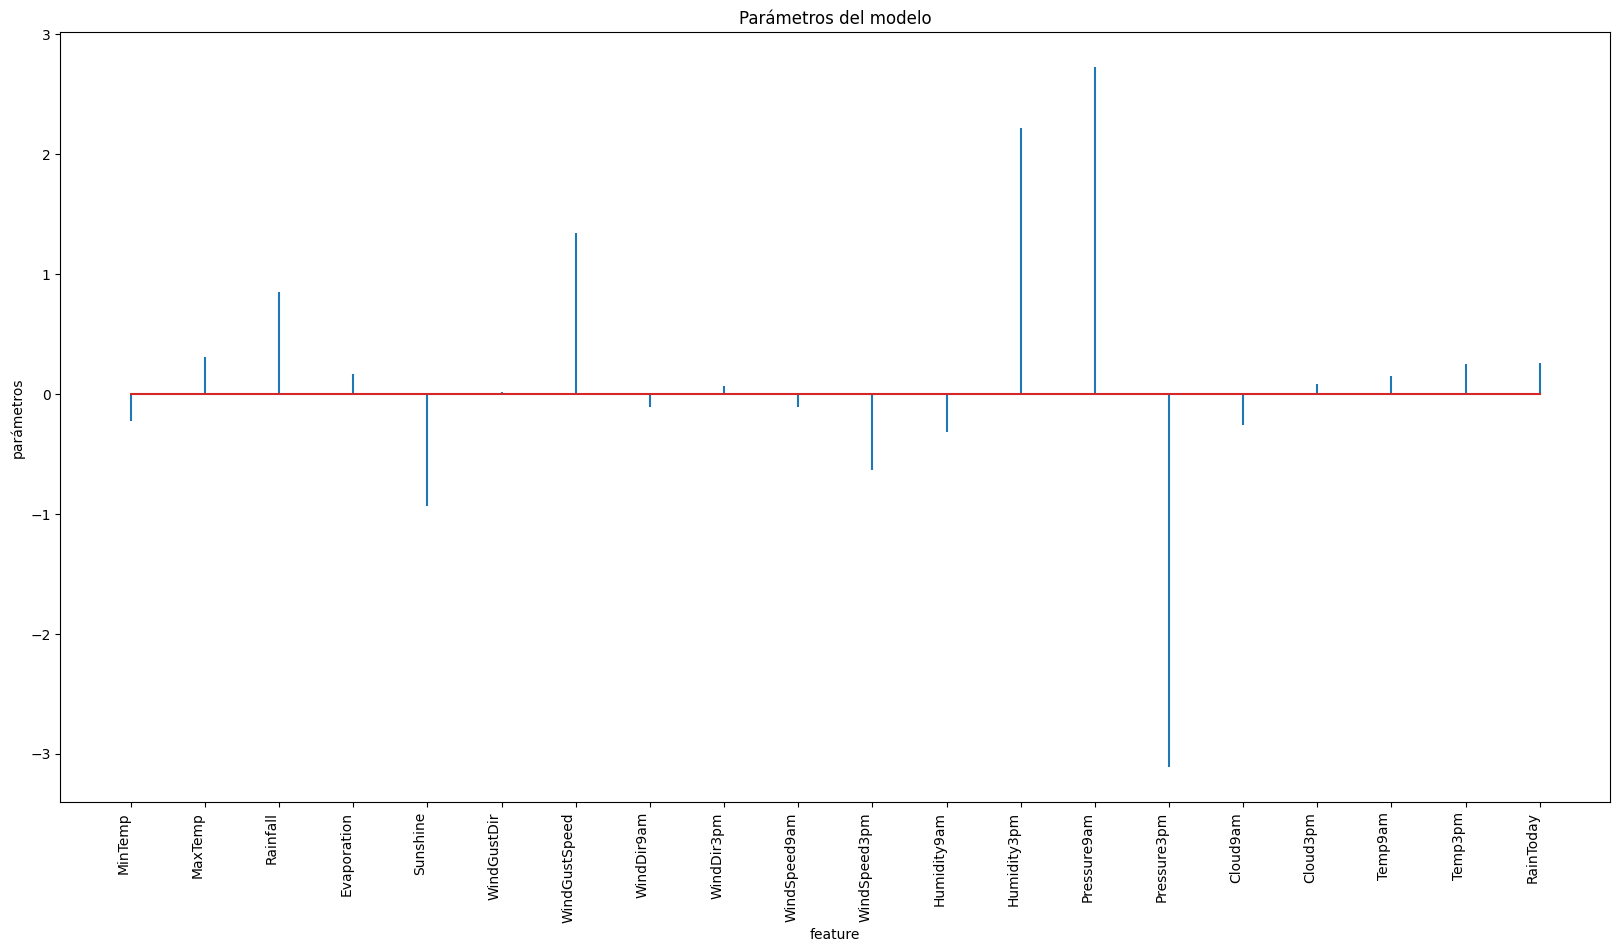

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
# Predicciones test
y_pred = modelo.predict(X_test)

In [ ]:
# Error de test del modelo 

rmse_elastic = mean_squared_error(y_test,y_pred, squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 5.541167778783857


In [ ]:
R2 = metrics.r2_score(y_test, y_pred)
R2

0.23255076525992524

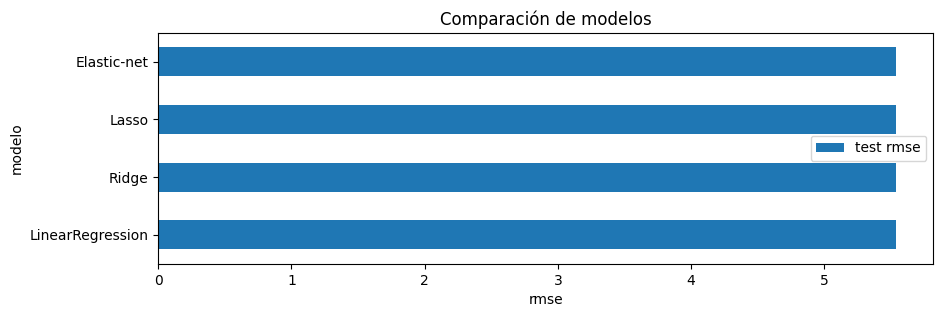

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');